In [1]:
import importlib
import warnings

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import json
import sys
import statsmodels.api as sm
import os
import kad.visualization.visualization as visualization
from kad.kad_utils.kad_utils import customize_matplotlib
import kad.models_evaluation.models_evaluator as models_evaluator

sys.path.insert(1, '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector')
print(sys.path)

import kad.ts_analyzer.ts_analyzer as ts_analyzer
from kad.model import i_model
from kad.model import sarima_model
from sklearn.model_selection import train_test_split

customize_matplotlib()

['/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/notebooks', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/IPython/extensions', '/home/maciek/.ipython']


# Reading data

In [17]:
data_dir = "data/archive/"
file_dir = "artificialWithAnomaly"
file_name = "artificialWithAnomaly/art_daily_flatmiddle.csv"
# file_dir = "artificialWithAnomaly"
# file_name = "artificialWithAnomaly/art_daily_jumpsup.csv"

file_path = os.path.join(data_dir, file_dir, file_name)

original_df = pd.read_csv(
    file_path, parse_dates=True, index_col="timestamp"
)

original_df = original_df.resample("h").agg(np.mean)

with open("data/archive/combined_windows.json") as f:
    true_anomalies = json.load(f)

# Data preprocessing

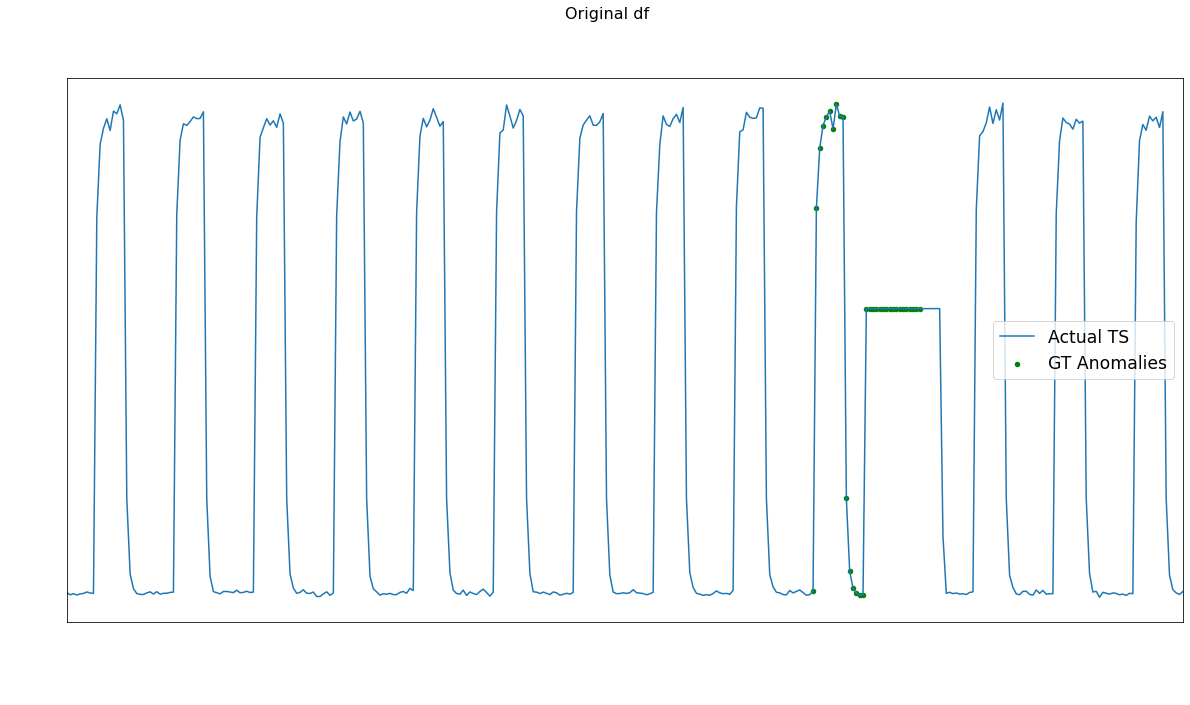

In [18]:
X_LABEL = "timestamp"
ts_analyzer = importlib.reload(ts_analyzer)
visualization = importlib.reload(visualization)

true_anomalies_ranges = true_anomalies[file_name]

ground_true_anomalies_df = pd.DataFrame()
for anom_range in true_anomalies_ranges:
    ground_true_anomalies_df = ground_true_anomalies_df.append(original_df.loc[anom_range[0]:anom_range[1]])

preprocessed_df = original_df.copy()
preprocessed_df["gt_is_anomaly"] = [idx in ground_true_anomalies_df.index for idx in original_df.index.tolist()]

visualization.visualize(results_df=preprocessed_df, metric_name="value", title="Original df")

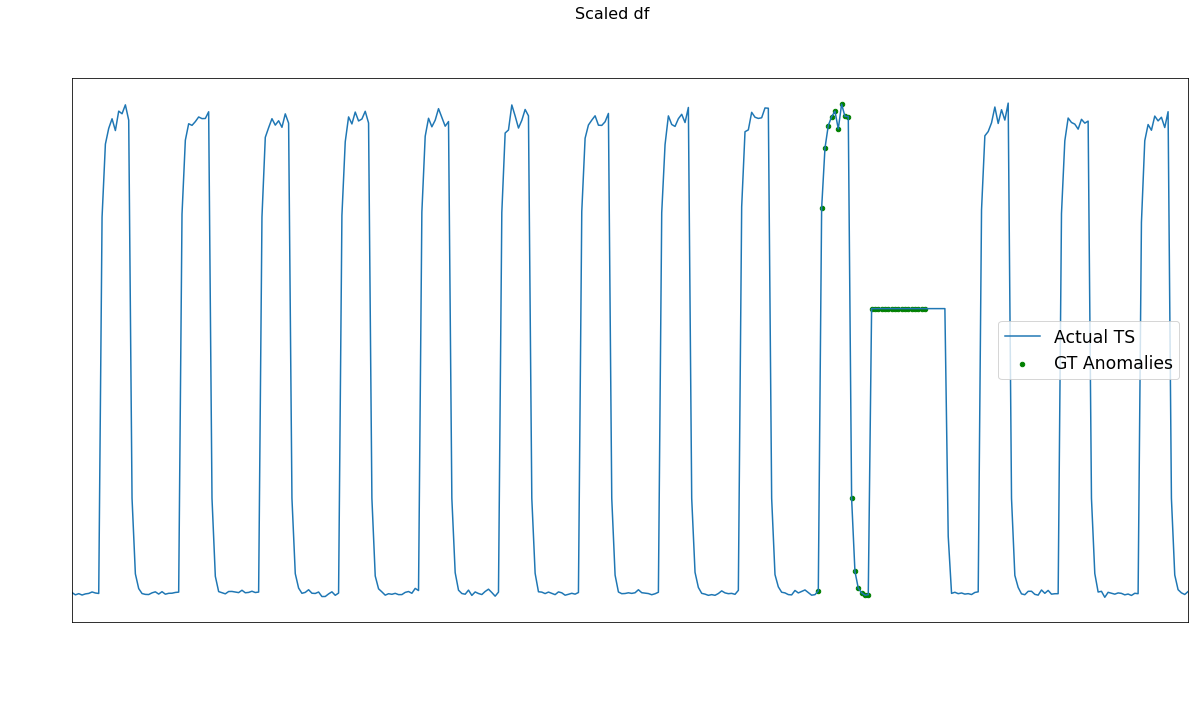

In [19]:
scaler = MinMaxScaler(feature_range=(-1, 0))
preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

visualization.visualize(results_df=preprocessed_df, metric_name="value", title="Scaled df")


In [20]:
values_df = preprocessed_df[["value"]]
tsa = ts_analyzer.TsAnalyzer(values_df)
print("Is TS stationary: ", tsa.is_stationary())


Statistics analysis

Statistic Test :  -10.211070086929512
p-value :  5.6365037513635285e-18
# n_lags :  12
No of observation:  323
 critical value 1% : -3.4507587628808922
 critical value 5% : -2.870530068560499
 critical value 10% : -2.5715597727381647
Is TS stationary:  True


Text(0.5, 0.98, 'ACF & PACF')

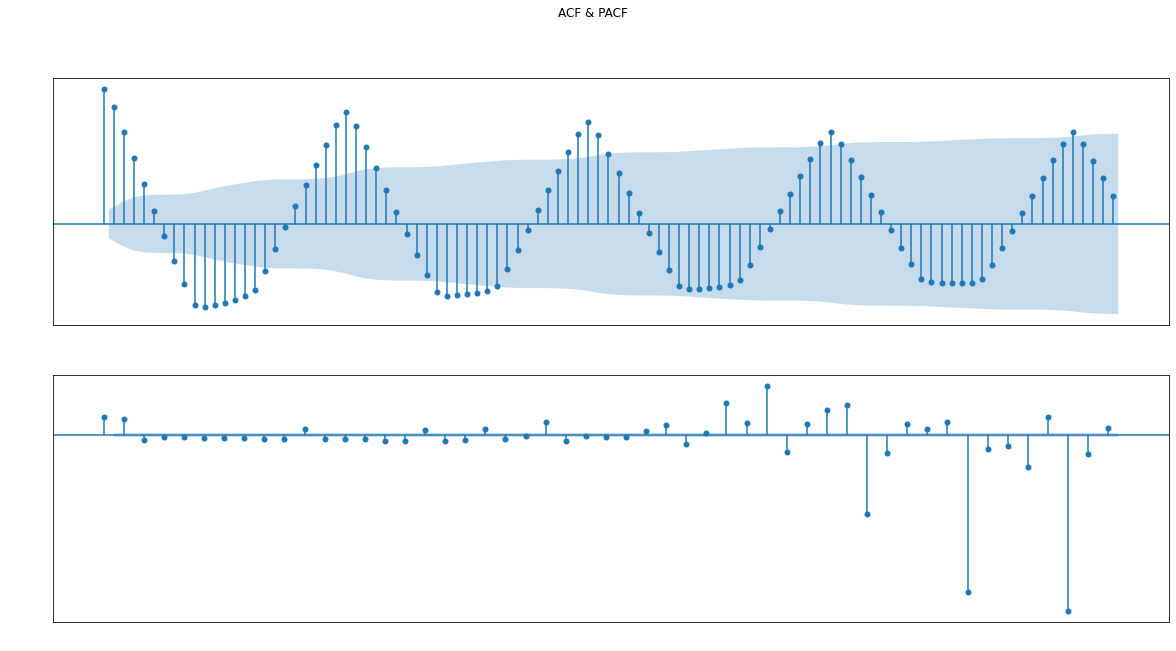

In [21]:
f = plt.figure(figsize=(20, 10))
ax = f.add_subplot(2, 1, 1)
_ = sm.graphics.tsa.plot_acf(values_df, lags=100, ax=ax)
ax2 = f.add_subplot(2, 1, 2)
_ = sm.graphics.tsa.plot_pacf(values_df, lags=50, ax=ax2)
f.suptitle("ACF & PACF")

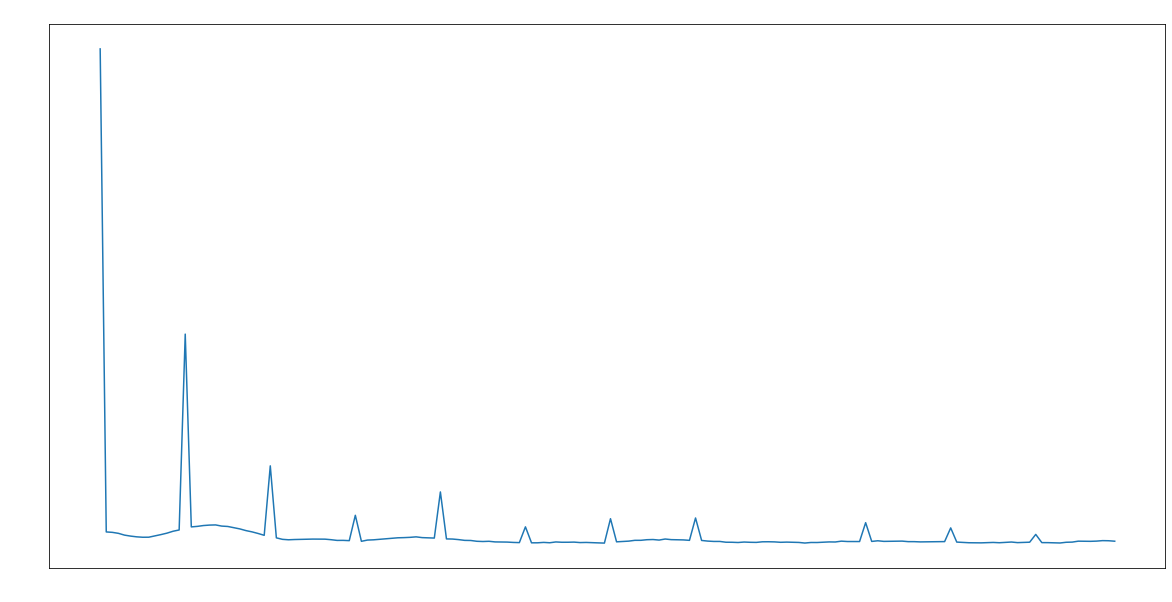

In [22]:
dominant_freq = tsa.calculate_dominant_frequency()

# SARIMA

                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                   35
Model:             SARIMAX(1, 0, [1], 24)   Log Likelihood                   9.686
Date:                    Thu, 13 May 2021   AIC                            -13.372
Time:                            17:09:40   BIC                             -8.706
Sample:                                 0   HQIC                           -11.761
                                     - 35                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.9998      0.000   7047.380      0.000       1.000       1.000
ma.S.L24       9.9127      2.532      3.915      0.000       4.950      14.875
sigma2        1.3e-0

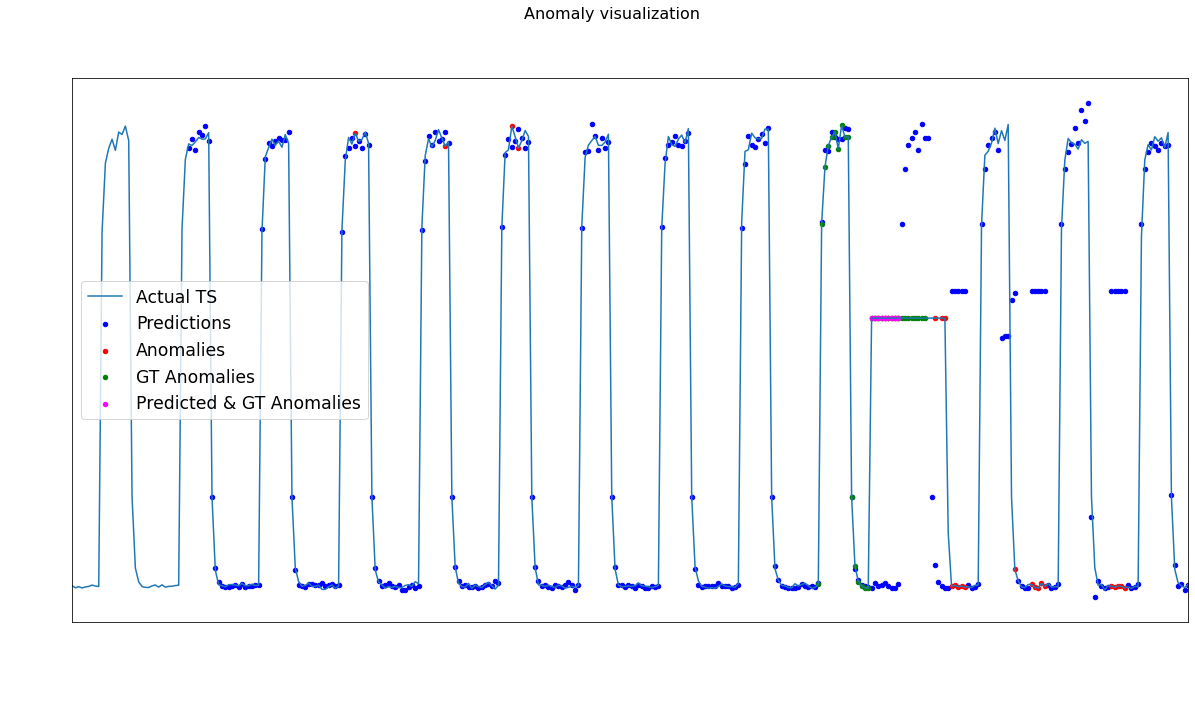

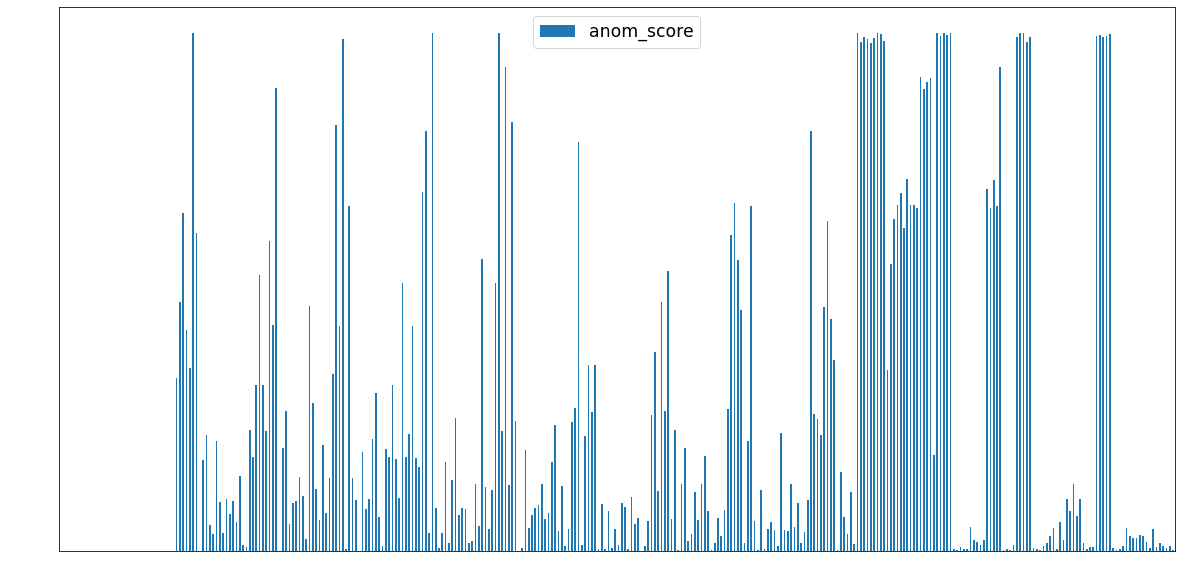

In [24]:
sarima_model = importlib.reload(sarima_model)

model: i_model.IModel = sarima_model.SarimaModel(order=(0, 0, 0), seasonal_order=(1, 0, 1, dominant_freq))

warnings.filterwarnings("ignore")
train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
model.train(train_df)

results_df = pd.DataFrame()
SAMPLES_TO_PREDICT = 5
for i in range(0, len(test_df), SAMPLES_TO_PREDICT):
    results_df = model.test(test_df.iloc[i:i + SAMPLES_TO_PREDICT])

visualization = importlib.reload(visualization)
evaluation_df = results_df.copy()
evaluation_df["gt_is_anomaly"] = preprocessed_df["gt_is_anomaly"]
visualization.visualize(evaluation_df, metric_name="value")

Accuracy:  0.8356643356643356
Avg precision:  0.27076494032442355


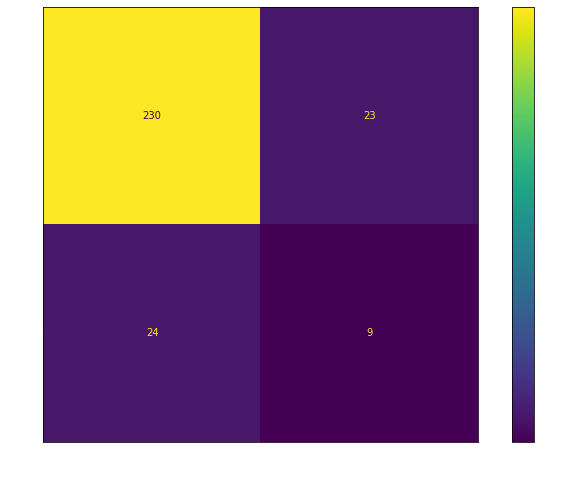

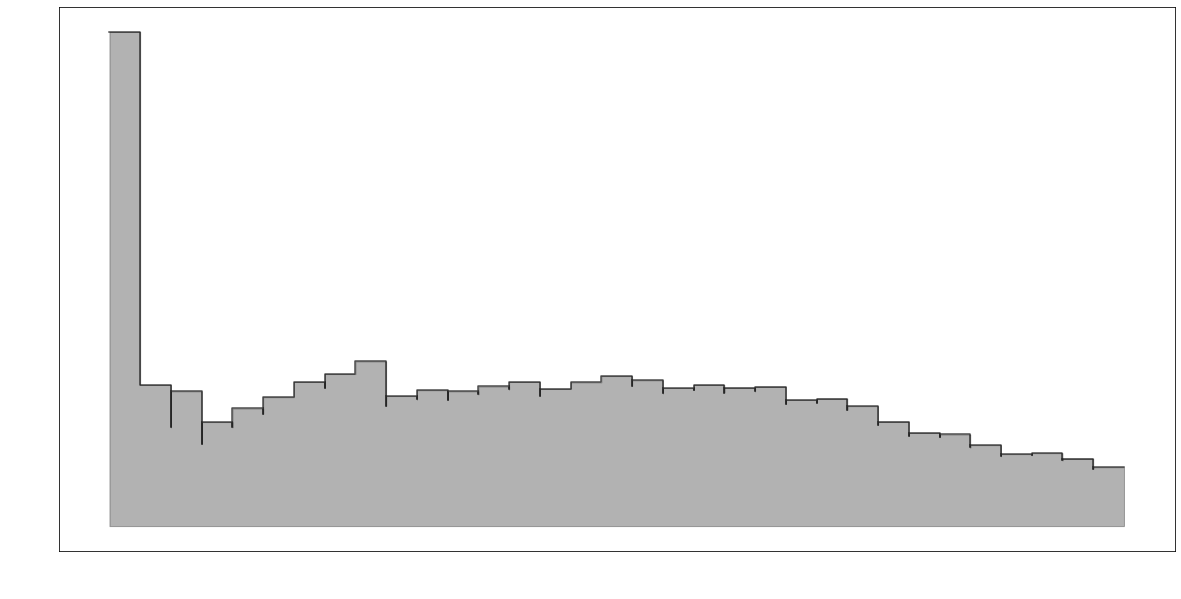

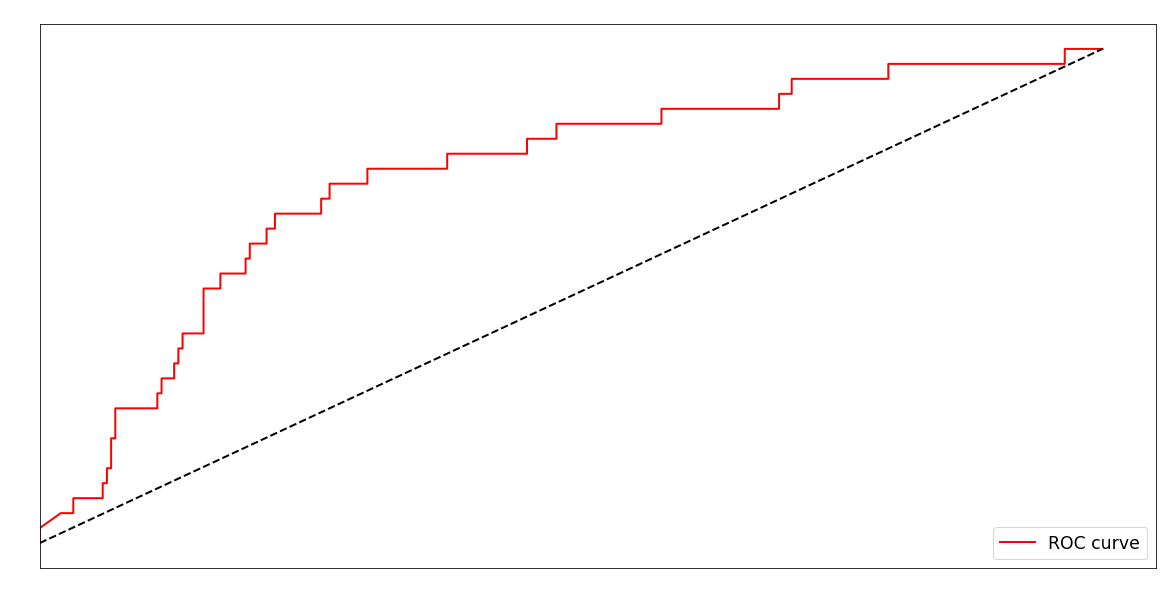

In [25]:
models_evaluator = importlib.reload(models_evaluator)

final_df = evaluation_df.loc[test_df.index & evaluation_df.index]
evaluator = models_evaluator.ModelsEvaluator(df=final_df)

print("Accuracy: ", evaluator.get_accuracy())
print("Avg precision: ", evaluator.get_average_precision())

evaluator.plot_confusion_matrix()

evaluator.plot_precision_recall_curve()
evaluator.plot_roc()

# SEARCHING FOR THE BEST PARAMS

In [10]:
import itertools

### Define Parameter Ranges to Test ###

# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]


### Run Grid Search ###

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='M'):
    '''
    Input:
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year.

    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts,  # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=True,
                                                enforce_invertibility=False)

                output = mod.fit(maxiter=maxiter)
                ans.append([comb, combs, output.bic])
                print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
            except Exception as exc:
                print(exc)
                continue

    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'], ascending=True)[0:5]

    return ans_df


### Apply function to your time series data ###

# Remember to change frequency to match your time series data
sarimax_gridsearch(train_df.values, pdq, pdqs, freq='D')

SARIMAX (0, 0, 0) x (0, 0, 0, 24)12 : BIC Calculated =130.29417373027252
SARIMAX (0, 0, 0) x (0, 0, 1, 24)12 : BIC Calculated =106.21937313802934
SARIMAX (0, 0, 0) x (0, 0, 2, 24)12 : BIC Calculated =92.43583489874788
SARIMAX (0, 0, 0) x (0, 1, 0, 24)12 : BIC Calculated =-174.56944858246874
SARIMAX (0, 0, 0) x (0, 1, 1, 24)12 : BIC Calculated =-171.31136484203705
SARIMAX (0, 0, 0) x (0, 1, 2, 24)12 : BIC Calculated =-168.05326889720087
SARIMAX (0, 0, 0) x (0, 2, 0, 24)12 : BIC Calculated =-13.044677327398395
SARIMAX (0, 0, 0) x (0, 2, 1, 24)12 : BIC Calculated =-12.351529290299723
SARIMAX (0, 0, 0) x (0, 2, 2, 24)12 : BIC Calculated =-11.65838324356501
SARIMAX (0, 0, 0) x (1, 0, 0, 24)12 : BIC Calculated =-86.40232648363367
SARIMAX (0, 0, 0) x (1, 0, 1, 24)12 : BIC Calculated =-96.7844205467444
SARIMAX (0, 0, 0) x (1, 0, 2, 24)12 : BIC Calculated =-92.31649599216246
SARIMAX (0, 0, 0) x (1, 1, 0, 24)12 : BIC Calculated =-171.3113693740817
SARIMAX (0, 0, 0) x (1, 1, 1, 24)12 : BIC Calcul

KeyboardInterrupt: 